In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [14]:
def fetch_stock_data(ticker, start_date):
    """
    Fetch daily stock price data using yfinance.

    :param ticker: Stock ticker symbol
    :param start_date: Start date for data retrieval (format: 'YYYY-MM-DD')
    :return: DataFrame containing the stock's historical price data
    """
    # Get current date to serve as the end date
    end_date = pd.Timestamp.now().strftime('%Y-%m-%d')
    
    # Download the stock price data from yfinance
    stock_data = yf.download(ticker, start=start_date, end="2021-01-01") # Observing for the pandemic period
    
    return stock_data

def detect_black_swan_events(data, z_threshold=-3, window=20, deviation_threshold=-3, percentile_threshold=1, abs_return_threshold=-0.05):
    """
    Detect black swan events using different threshold methods.
    
    :param data: DataFrame containing stock price data with a 'Close' column
    :param z_threshold: Z-score threshold for daily returns (default: -3 standard deviations)
    :param window: Rolling window size for price deviation method (default: 20 days)
    :param deviation_threshold: Threshold for price deviations from rolling mean (default: -3 standard deviations)
    :param percentile_threshold: Lower percentile threshold for daily returns (default: 1%)
    :param abs_return_threshold: Absolute daily return threshold (default: -5%)
    :return: DataFrame with additional columns for black swan events from each method
    """
    
    ### Method 1: Z-score based on daily returns
    # Calculate daily returns
    data['Daily Return'] = data['Close'].pct_change()
    
    # Compute Z-scores for daily returns
    data['Z-Score'] = zscore(data['Daily Return'].dropna())
    
    # Identify black swan events using Z-score threshold
    data['BlackSwan_ZScore'] = np.where(data['Z-Score'] < z_threshold, 1, 0)

    ### Method 2: Price deviation over rolling standard deviation
    # Calculate rolling mean and rolling standard deviation
    data['Rolling Mean'] = data['Close'].rolling(window=window).mean()
    data['Rolling Std'] = data['Close'].rolling(window=window).std()

    # Calculate price deviation from rolling mean in terms of rolling standard deviations
    data['Price Deviation'] = (data['Close'] - data['Rolling Mean']) / data['Rolling Std']

    # Identify black swan events using price deviation threshold
    data['BlackSwan_Deviation'] = np.where(data['Price Deviation'] < deviation_threshold, 1, 0)

    ### Method 3: Percentile-based threshold
    # Calculate the threshold for the lowest `percentile_threshold` percentile of daily returns
    percentile_value = np.percentile(data['Daily Return'].dropna(), percentile_threshold)

    # Identify black swan events based on the percentile threshold
    data['BlackSwan_Percentile'] = np.where(data['Daily Return'] < percentile_value, 1, 0)

    ### Method 4: Absolute return threshold
    # Identify black swan events where daily return is less than the absolute return threshold
    data['BlackSwan_AbsReturn'] = np.where(data['Daily Return'] < abs_return_threshold, 1, 0)
    
    # Filter rows where at least one method detected a black swan event
    black_swan_events = data.loc[
        (data['BlackSwan_ZScore'] == 1) | 
        (data['BlackSwan_Deviation'] == 1) | 
        (data['BlackSwan_Percentile'] == 1) | 
        (data['BlackSwan_AbsReturn'] == 1)
    ]
    
    print(f"Detected black swan events (Z-score: {len(data[data['BlackSwan_ZScore'] == 1])}, "
          f"Price Deviation: {len(data[data['BlackSwan_Deviation'] == 1])}, "
          f"Percentile: {len(data[data['BlackSwan_Percentile'] == 1])}, "
          f"Abs Return: {len(data[data['BlackSwan_AbsReturn'] == 1])})")
    
    return data, black_swan_events

def plot_black_swan_events(ticker, data):
    """
    Plot stock prices with black swan events detected by each method separately.

    :param ticker: Stock ticker symbol
    :param data: DataFrame containing stock price data and black swan event markers from each method
    """
    # Set up the plotting canvas with 4 subplots
    fig, axes = plt.subplots(4, 1, figsize=(14, 16), sharex=True)

    # Method 1: Z-score based black swan events
    axes[0].plot(data.index, data['Close'], label='Close Price', color='blue', alpha=0.5)
    axes[0].scatter(data.index[data['BlackSwan_ZScore'] == 1], data['Close'][data['BlackSwan_ZScore'] == 1], 
                    color='red', marker='o', label='Black Swan (Z-Score)', s=100)
    axes[0].set_title(f'{ticker} - Black Swan Events (Z-Score Method)')
    axes[0].set_ylabel('Price')
    axes[0].legend()
    axes[0].grid(True)

    # Method 2: Price deviation over rolling standard deviation
    axes[1].plot(data.index, data['Close'], label='Close Price', color='blue', alpha=0.5)
    axes[1].scatter(data.index[data['BlackSwan_Deviation'] == 1], data['Close'][data['BlackSwan_Deviation'] == 1], 
                    color='green', marker='o', label='Black Swan (Price Deviation)', s=100)
    axes[1].set_title(f'{ticker} - Black Swan Events (Price Deviation Method)')
    axes[1].set_ylabel('Price')
    axes[1].legend()
    axes[1].grid(True)

    # Method 3: Percentile-based black swan events
    axes[2].plot(data.index, data['Close'], label='Close Price', color='blue', alpha=0.5)
    axes[2].scatter(data.index[data['BlackSwan_Percentile'] == 1], data['Close'][data['BlackSwan_Percentile'] == 1], 
                    color='purple', marker='o', label='Black Swan (Percentile)', s=100)
    axes[2].set_title(f'{ticker} - Black Swan Events (Percentile Method)')
    axes[2].set_ylabel('Price')
    axes[2].legend()
    axes[2].grid(True)

    # Method 4: Absolute return threshold black swan events
    axes[3].plot(data.index, data['Close'], label='Close Price', color='blue', alpha=0.5)
    axes[3].scatter(data.index[data['BlackSwan_AbsReturn'] == 1], data['Close'][data['BlackSwan_AbsReturn'] == 1], 
                    color='orange', marker='o', label='Black Swan (Abs Return)', s=100)
    axes[3].set_title(f'{ticker} - Black Swan Events (Absolute Return Method)')
    axes[3].set_ylabel('Price')
    axes[3].set_xlabel('Date')
    axes[3].legend()
    axes[3].grid(True)

    plt.tight_layout()
    plt.show()


[*********************100%%**********************]  1 of 1 completed


Detected black swan events (Z-score: 4, Price Deviation: 2, Percentile: 6, Abs Return: 5)


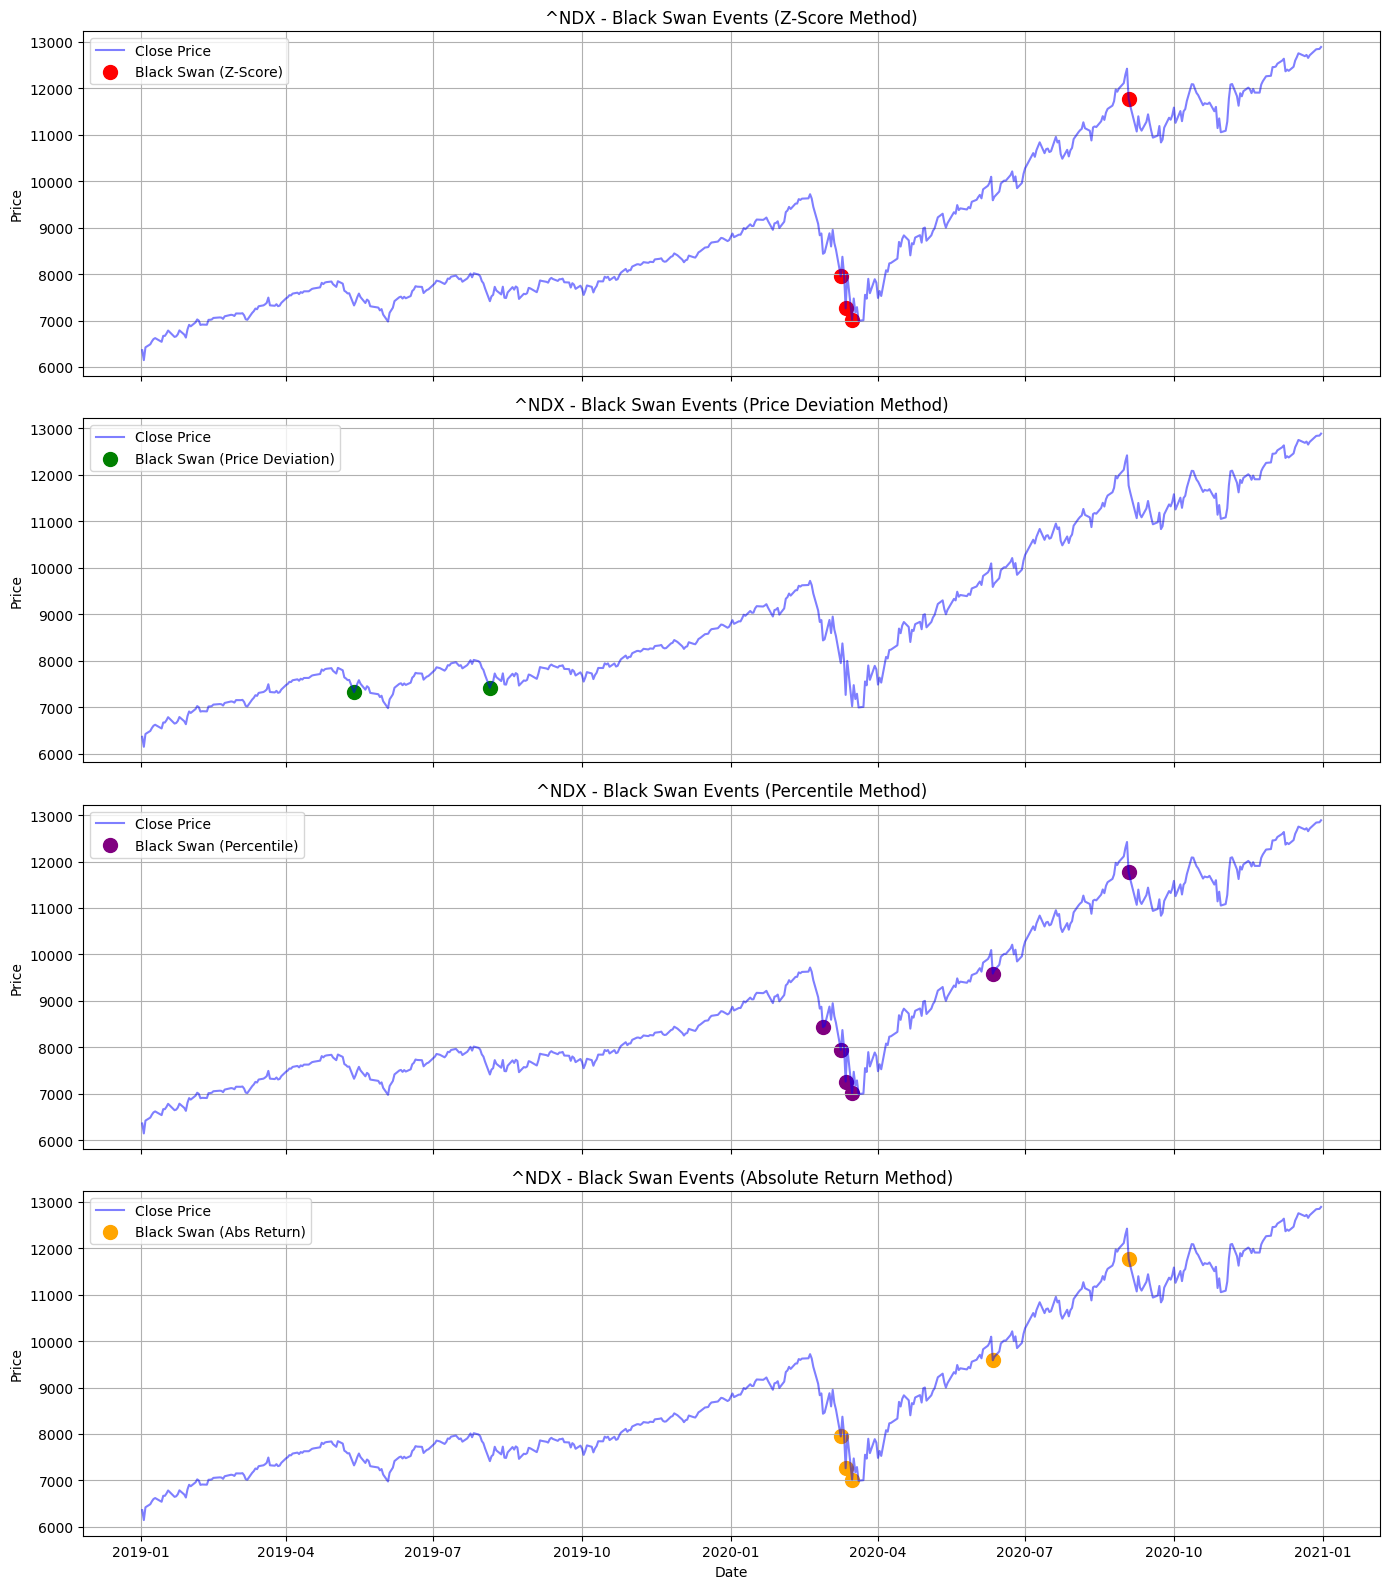

In [18]:
# Example usage
ticker = '^NDX'
start_date = '2019-01-01'

# Fetch stock data
stock_data = fetch_stock_data(ticker, start_date)

# Detect black swan events using all methods
stock_data, black_swan_events = detect_black_swan_events(stock_data, 
                                                         z_threshold=-3, 
                                                         window=20, 
                                                         deviation_threshold=-3, 
                                                         percentile_threshold=1, 
                                                         abs_return_threshold=-0.05)

# Plot black swan events separately for each method
plot_black_swan_events(ticker, stock_data)